# Categorizing text based on keyword matching

Sometimes instead of using a fancy classifier or topic modeling, you just want to do a simple keyword search to assign categories to your data points. For example: it has "cat" or "dog" we'll label it pets, if it has "boat" or "train" we'll label it transportation. In this case we're reproducing [this Bloomberg piece](https://www.bloomberg.com/graphics/2020-democratic-presidential-candidate-policies/).

<p class="reading-options">
  <a class="btn" href="/bloomberg-tweet-topics/assigning-categories-to-text-using-keyword-matching">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/bloomberg-tweet-topics/notebooks/Assigning categories to text using keyword matching.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/bloomberg-tweet-topics/notebooks/Assigning categories to text using keyword matching.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **tweets.csv:** raw tweets - Approximately 39k tweets from Democratic presidential candidates


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/bloomberg-tweet-topics/data/tweets.csv -P data

## Our data

We have billions upon billions of tweets from Democratic presidential candidates, let's see if we can put them into categories. Topic modeling didn't work out so hot, so we're going to do this manually now.

In [1]:
import pandas as pd

# We don't need all of the columns, let's leave out a lot of them
columns = ['username', 'text', 'date']

df = pd.read_csv("data/tweets.csv", usecols=columns)
df.sample(5)

username                                               text  \
36633     AndrewYang    As a politician I’m a pretty good entrepreneur.   
37588     AndrewYang  Would you believe that we are passing 28,000 d...   
26789     CoryBooker                                   It's about time.   
13770  marwilliamson  All that a country is is a collection of peopl...   
15597  marwilliamson  The USA has essentially reverted to an aristoc...   

                            date  
36633  2019-03-27 19:45:19+00:00  
37588  2019-02-24 03:39:36+00:00  
26789  2019-04-18 03:01:23+00:00  
13770  2019-07-31 02:43:47+00:00  
15597  2019-02-20 13:06:50+00:00

In [2]:
df.shape

(38559, 3)

Sorry, not billions of tweets - more like 39k.

## Categorizing the tweets

We're going to work off of [Austin Wehrwein's take (in R)](https://austinwehrwein.com/data-visualization/2020candidates/), where he made a short short list of words associated with teach topic. Our approach is going to be kind of awkward, but it's pretty flexible for things you might want to do in the future.

In [3]:
# We're only using single words (no "green new deal") because the
# stemmer won't work with multiple words

categories = {
    'immigration': ['immigration', 'border', 'wall'],
    'education': ['students', 'education', 'teacher'],
    'foreign_policy': ['foreign policy', 'peace'],
    'climate_change': ['climate', 'emissions', 'carbon'],
    'economy': ['economy', 'tariffs', 'taxes'],
    'military': ['veterans', 'troops', 'war'],
    'jobs': ['jobs', 'unemployment', 'wages'],
    'drugs': ['drugs', 'opioid'],
    'health': ['health', 'insurance', 'medicare'],
    'repro_rights': ['reproductive', 'abortion'],
    'gun_control': ['gun'],
}
categories

{'immigration': ['immigration', 'border', 'wall'],
 'education': ['students', 'education', 'teacher'],
 'foreign_policy': ['foreign policy', 'peace'],
 'climate_change': ['climate', 'emissions', 'carbon'],
 'economy': ['economy', 'tariffs', 'taxes'],
 'military': ['veterans', 'troops', 'war'],
 'jobs': ['jobs', 'unemployment', 'wages'],
 'drugs': ['drugs', 'opioid'],
 'health': ['health', 'insurance', 'medicare'],
 'repro_rights': ['reproductive', 'abortion'],
 'gun_control': ['gun']}

We'll turn these into a nice long dataframe of words and category names. We'll also stem the keywords so they'll match a bit more broadly. For exampe, `immigrant`, `immigrants`, and `immigration` will all end up as `immigr`.

> "green new deal" ends up as "green new d" when stemmed, so we'll stick with single words.

In [4]:
import Stemmer

stemmer = Stemmer.Stemmer('en')

dfs = []
for key,values in categories.items():
    words = pd.DataFrame({'category': key, 'term': stemmer.stemWords(values)})
    dfs.append(words)

terms_df = pd.concat(dfs)

terms_df

category            term
0     immigration          immigr
1     immigration          border
2     immigration            wall
0       education         student
1       education            educ
2       education         teacher
0  foreign_policy  foreign polici
1  foreign_policy            peac
0  climate_change          climat
1  climate_change           emiss
2  climate_change          carbon
0         economy         economi
1         economy          tariff
2         economy             tax
0        military         veteran
1        military           troop
2        military             war
0            jobs             job
1            jobs        unemploy
2            jobs            wage
0           drugs            drug
1           drugs          opioid
0          health          health
1          health           insur
2          health         medicar
0    repro_rights       reproduct
1    repro_rights           abort
0     gun_control             gun

Now we're going to do a very unique kind of vectorizer: **we're only going to count words in this list**, and we're also **only going to say yes/no for each of them.**

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import Stemmer

# Using pyStemmer because it's way faster than NLTK
stemmer = Stemmer.Stemmer('en')

# Based on CountVectorizer
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords([w for w in analyzer(doc)])

In [6]:
# Take the 'term' column from our list of terms
term_list = list(terms_df.term)

# binary=True only does 0/1
# vocabulary= is the list of words we're interested in tracking
vectorizer = StemmedCountVectorizer(binary=True, vocabulary=term_list)
matrix = vectorizer.fit_transform(df.text)
words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df.head()

immigr  border  wall  student  educ  teacher  foreign polici  peac  climat  \
0       0       0     0        0     0        0               0     0       0   
1       0       0     0        0     0        0               0     0       0   
2       0       0     0        0     0        0               0     0       0   
3       0       0     0        0     0        1               0     0       0   
4       0       0     0        0     0        0               0     0       0   

   emiss  ...  unemploy  wage  drug  opioid  health  insur  medicar  \
0      0  ...         0     0     0       0       0      0        0   
1      0  ...         0     0     0       0       0      0        0   
2      0  ...         0     0     0       0       0      0        0   
3      0  ...         0     0     0       0       0      0        0   
4      0  ...         0     0     0       0       0      0        0   

   reproduct  abort  gun  
0          0      0    0  
1          0      0    0  
2          0      0    0  
3          0      0    0  
4          0      0    0  

[5 rows x 28 columns]

Out of the first five tweets, it looks like only the fourth one fits into a category - it includes the word **teacher**, so we'll put it into the education group. 

We're going to **loop through each category**, and then see if any of the terms for that category have a `1` in them. If so, we'll assign that row a `1` for the category. If not, we'll give it a `0`.

For example, row 3 does not have `student` or `educ`, but it does have `teacher`. As a result, it will get a `1` for the education category.

In [7]:
# Group the terms by category, then loop through each category
for category_name, rows in terms_df.groupby('category'):
    # Convert the terms for that category into a simple list
    # for example, ['student', 'educ', 'teacher']
    terms = list(rows['term'])
    print(f"Looking at {category_name} with terms {terms}")

    # words_df[terms] gets the columns for 'student', 'educ', and 'teacher'
    # .any(axis=1) sees if any of them are a 1, gives True/False
    # .astype(int) converts True/False to 1/0
    # df[category_name] = will assign that value to df['education']
    df[category_name] = words_df[terms].any(axis=1).astype(int)

Looking at climate_change with terms ['climat', 'emiss', 'carbon']
Looking at drugs with terms ['drug', 'opioid']
Looking at economy with terms ['economi', 'tariff', 'tax']
Looking at education with terms ['student', 'educ', 'teacher']
Looking at foreign_policy with terms ['foreign polici', 'peac']
Looking at gun_control with terms ['gun']
Looking at health with terms ['health', 'insur', 'medicar']
Looking at immigration with terms ['immigr', 'border', 'wall']
Looking at jobs with terms ['job', 'unemploy', 'wage']
Looking at military with terms ['veteran', 'troop', 'war']
Looking at repro_rights with terms ['reproduct', 'abort']


Let's see how it looks.

In [8]:
df.sample(4)

username                                               text  \
4676    BetoORourke  Grateful for the opportunity to bring everyone...   
7526       JoeBiden  Trump continues to undermine our standing in t...   
5729   amyklobuchar  AG Barr told me to ask Director Mueller for Pr...   
18305     JayInslee  Donald Trump is for environmentalism like he i...   

                            date  climate_change  drugs  economy  education  \
4676   2019-04-19 14:57:00+00:00               0      0        0          0   
7526   2019-06-19 01:34:30+00:00               0      0        0          0   
5729   2019-05-09 12:05:49+00:00               0      0        1          0   
18305  2019-07-09 23:46:04+00:00               0      0        0          0   

       foreign_policy  gun_control  health  immigration  jobs  military  \
4676                0            0       0            0     0         0   
7526                0            0       0            0     0         0   
5729                0            0       0            0     0         0   
18305               0            0       0            0     0         0   

       repro_rights  
4676              0  
7526              0  
5729              0  
18305             0

Many of these don't have categories, but we did a really really really bad job coming up with a list of terms. In the "real world" you'd probably have more than three keywords per category!

Let's take a second to **save the labeled tweets**, as we'll need them in the future.

In [9]:
df.to_csv("data/tweets-categorized.csv", index=False)

## Exploring categorized tweets

Now that we have a set of tweets that are labeled with different categories, we can start to count and classify them. For example, we can see how tweets the most about jobs.

In [10]:
df.groupby('username').jobs.sum().sort_values(ascending=False)

username
BernieSanders      218
AndrewYang         132
ewarren            122
JohnDelaney        118
JayInslee          113
KamalaHarris       113
TimRyan             82
GovernorBullock     75
BetoORourke         63
Hickenlooper        60
marwilliamson       59
SenGillibrand       52
CoryBooker          51
WayneMessam         41
JoeBiden            41
TomSteyer           40
amyklobuchar        39
sethmoulton         38
BilldeBlasio        31
JulianCastro        30
PeteButtigieg       29
TulsiGabbard        27
MichaelBennet       26
ericswalwell        19
JoeSestak           15
Name: jobs, dtype: int64

In fact, since these 0's and 1's are our **only numeric columns**, we can just ask the dataframe to group by username and add up every category.

In [11]:
overall = df.groupby('username').sum()
overall

climate_change  drugs  economy  education  foreign_policy  \
username                                                                     
AndrewYang                   41     20      142         65               2   
BernieSanders                87     72      111        146              16   
BetoORourke                  86     23       57        146               9   
BilldeBlasio                 10      1       18         13               1   
CoryBooker                   18     37       26         39               4   
GovernorBullock              62     19       59         63               2   
Hickenlooper                 46      9       70         20               7   
JayInslee                   747      4      121         53               3   
JoeBiden                     40      7       48         48              16   
JoeSestak                    32      6       29         16               9   
JohnDelaney                 130     43      152         64               3   
JulianCastro                 25      2       20         55               4   
KamalaHarris                 65     31       88        200               8   
MichaelBennet                54     11       58         69               0   
PeteButtigieg                24      2       24         27               6   
SenGillibrand                54     19       54         51               8   
TimRyan                      42     18       92        103               7   
TomSteyer                   117      2       67         26               3   
TulsiGabbard                 15     14       27         18              39   
WayneMessam                  16      1       40         80               6   
amyklobuchar                 45     56       47         41               3   
ericswalwell                 12      6       26         58               7   
ewarren                      79     44      151        195               1   
marwilliamson                23     13       63         53              87   
sethmoulton                  43     16       40         24               9   

                 gun_control  health  immigration  jobs  military  \
username                                                            
AndrewYang                21      51           27   132        38   
BernieSanders             38     321          123   218        73   
BetoORourke               83     126          165    63        94   
BilldeBlasio              11      29           14    31         8   
CoryBooker               108      62           49    51        33   
GovernorBullock           30      34           32    75        32   
Hickenlooper              72      43           24    60        23   
JayInslee                 41      64           52   113        28   
JoeBiden                  37      72           37    41        20   
JoeSestak                  1      21           22    15        30   
JohnDelaney               14     152           58   118        37   
JulianCastro              28      37          139    30        14   
KamalaHarris             147     208           94   113        23   
MichaelBennet             19     124           29    26        15   
PeteButtigieg             21      35           11    29        29   
SenGillibrand             62     127           57    52        23   
TimRyan                   32     126           18    82        30   
TomSteyer                 27      17           55    40        18   
TulsiGabbard               1      22           16    27       160   
WayneMessam               27      13           35    41         4   
amyklobuchar              59      82           31    39        18   
ericswalwell             182      37           36    19        35   
ewarren                   65      95          131   122        29   
marwilliamson             18      46           37    59        79   
sethmoulton               34      60           49    38       110   

                 repro_rights  
username      

The problem with this view is that some candidates tweet a lot, and some candidates tweet much less. If we graph it, it isn't going to give a good view of what topics the candidates' campaigns value.

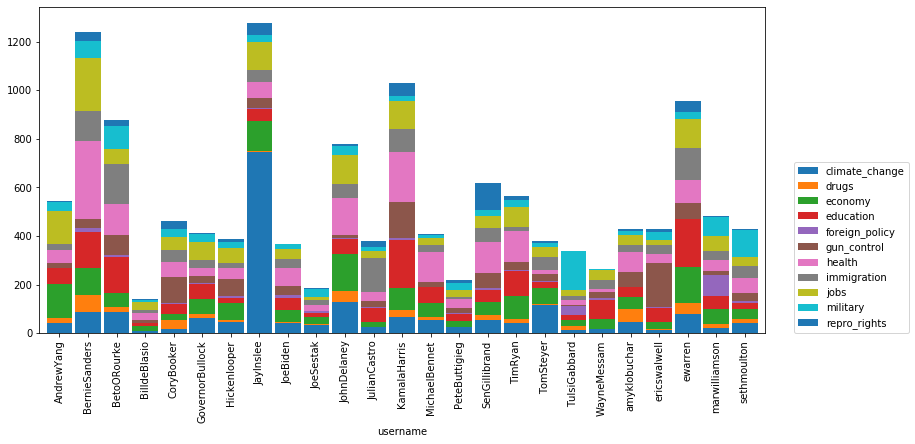

In [12]:
ax = overall.plot(kind='bar', stacked=True, figsize=(13,6), width=0.9)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

What we need is for this to be **based on percentages**. In order to do that, we'll need to **divide each column by the sum of the counts in that column**. Because of Weird Pandas Magic we'll need to use `.div` instead of `/`. The division sign might not give you an error but it will definitely give you incorrect results!

In [13]:
overall_pct = overall.div(overall.sum(axis=1), axis=0)
overall_pct

climate_change     drugs   economy  education  \
username                                                         
AndrewYang             0.075368  0.036765  0.261029   0.119485   
BernieSanders          0.070105  0.058018  0.089444   0.117647   
BetoORourke            0.098174  0.026256  0.065068   0.166667   
BilldeBlasio           0.071429  0.007143  0.128571   0.092857   
CoryBooker             0.039130  0.080435  0.056522   0.084783   
GovernorBullock        0.150852  0.046229  0.143552   0.153285   
Hickenlooper           0.118252  0.023136  0.179949   0.051414   
JayInslee              0.584050  0.003127  0.094605   0.041439   
JoeBiden               0.109290  0.019126  0.131148   0.131148   
JoeSestak              0.170213  0.031915  0.154255   0.085106   
JohnDelaney            0.167310  0.055341  0.195624   0.082368   
JulianCastro           0.066138  0.005291  0.052910   0.145503   
KamalaHarris           0.063046  0.030068  0.085354   0.193986   
MichaelBennet          0.132353  0.026961  0.142157   0.169118   
PeteButtigieg          0.108597  0.009050  0.108597   0.122172   
SenGillibrand          0.087379  0.030744  0.087379   0.082524   
TimRyan                0.074600  0.031972  0.163410   0.182948   
TomSteyer              0.309524  0.005291  0.177249   0.068783   
TulsiGabbard           0.044118  0.041176  0.079412   0.052941   
WayneMessam            0.060377  0.003774  0.150943   0.301887   
amyklobuchar           0.104895  0.130536  0.109557   0.095571   
ericswalwell           0.027907  0.013953  0.060465   0.134884   
ewarren                0.082723  0.046073  0.158115   0.204188   
marwilliamson          0.047619  0.026915  0.130435   0.109731   
sethmoulton            0.100467  0.037383  0.093458   0.056075   

                 foreign_policy  gun_control    health  immigration      jobs  \
username                                                                        
AndrewYang             0.003676     0.038603  0.093750     0.049632  0.242647   
BernieSanders          0.012893     0.030620  0.258662     0.099114  0.175665   
BetoORourke            0.010274     0.094749  0.143836     0.188356  0.071918   
BilldeBlasio           0.007143     0.078571  0.207143     0.100000  0.221429   
CoryBooker             0.008696     0.234783  0.134783     0.106522  0.110870   
GovernorBullock        0.004866     0.072993  0.082725     0.077859  0.182482   
Hickenlooper           0.017995     0.185090  0.110540     0.061697  0.154242   
JayInslee              0.002346     0.032056  0.050039     0.040657  0.088350   
JoeBiden               0.043716     0.101093  0.196721     0.101093  0.112022   
JoeSestak              0.047872     0.005319  0.111702     0.117021  0.079787   
JohnDelaney            0.003861     0.018018  0.195624     0.074646  0.151866   
JulianCastro           0.010582     0.074074  0.097884     0.367725  0.079365   
KamalaHarris           0.007759     0.142580  0.201746     0.091174  0.109602   
MichaelBennet          0.000000     0.046569  0.303922     0.071078  0.063725   
PeteButtigieg          0.027149     0.095023  0.158371     0.049774  0.131222   
SenGillibrand          0.012945     0.100324  0.205502     0.092233  0.084142   
TimRyan                0.012433     0.056838  0.223801     0.031972  0.145648   
TomSteyer              0.007937     0.071429  0.044974     0.145503  0.105820   
TulsiGabbard           0.114706     0.002941  0.064706     0.047059  0.079412   
WayneMessam            0.022642     0.101887  0.049057     0.132075  0.154717   
amyklobuchar           0.006993     0.137529  0.191142     0.072261  0.090909   
ericswalwell           0.016279     0.423256  0.086047     0.083721  0.044186   
ewarren                0.001047     0.068063  0.099476     0.137173  0.127749   
marwilliamson          0.180124     0.037267  0.095238     0.076605  0.122153   
sethmoulton            0.021028     0.079439  0.140187     0.114486  0.088785   

                 military  repro_rights  
user

Now we can plot it successfully!

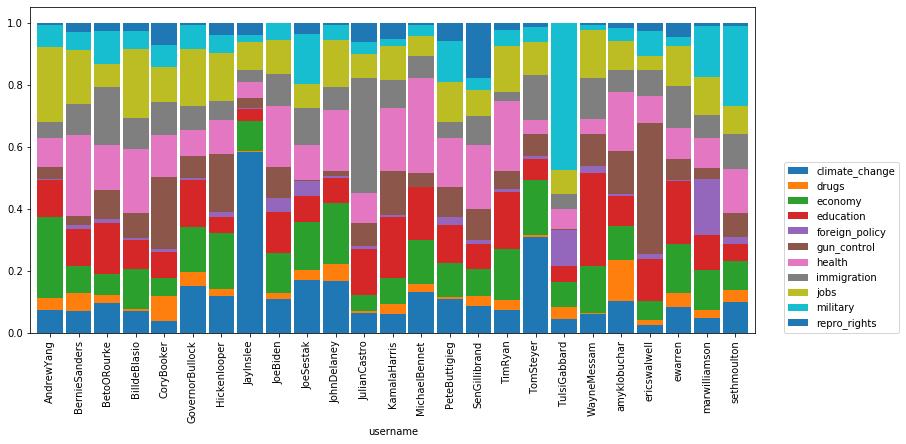

In [14]:
ax = overall_pct.plot(kind='bar', stacked=True, figsize=(13,6), width=0.9)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

Matplotlib is pretty horrifying to look at, though, so we might want to upgrade to using plotly instead of the normal `.plot`. Unfortunately that will involve **reshaping our data!**

In [15]:
reshaped = overall_pct.reset_index().melt(id_vars=['username'], var_name='topic', value_name='pct')
reshaped.head()

username           topic       pct
0     AndrewYang  climate_change  0.075368
1  BernieSanders  climate_change  0.070105
2    BetoORourke  climate_change  0.098174
3   BilldeBlasio  climate_change  0.071429
4     CoryBooker  climate_change  0.039130

Once it's reshaped we're free to plot.

In [16]:
import plotly.express as px

fig = px.bar(reshaped, x='username', y='pct', color='topic')
fig.show()

## Review

In this section we learned how to categorized text based on lists of words.

## Discussion topics

How does this approach compare to someting like classification? Is there a difference?

With this approach we're double-counting tweets that fall into two categories (for example, a tweet could count for **climate change** as well as **foreign policy**). Should this give us a panic attack regarding our 100% stacked bar graph? Why or why not?

What is stressed in the data differently between the "normal" stacked bar as compared to the 100% stacked bar?

What is an alternative method we could use instead of counting the tweet as being once for climate change and once for foreign policy? We don't need to implement it, just figure an alternative out.